# Tashkent Accessibility Analysis with Floods

- This analysis will measure accessibility to schools and hospitals
- Origins are derived from 250m grid blocks coming from GHSL POP
- The accessibility measure is the time to the nearest facility in seconds

## Inputs:

#### origins: derived from a GHSL POP raster (WorldPop did not visually seem as accurate) manually using the 'Raster pixels to Points' tool in QGIS 3, and saved as a shapefile
#### destinations: The combination of POIs from Overpass as points and centroids of polygons called through the GOSTNets OSMNX_POIs library.
#### The admin AOI will be used to create a bounding box to download the road network via OSMNX


### Import libraries

In [3]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [4]:
# Get reference to OSMNX_POIs
sys.path.append(r'../..')
from Market_Access import OSMNX_POIs

In [5]:
# Get reference to GOSTNets
sys.path.append(r'../../../GOSTnets')
import GOSTnets as gn

In [6]:
# define output folder
inputFolder = r'input_folder'
# define output folder
outputFolder = r'output_folder'
# define road graph
roadGraph = os.path.join(inputFolder, "OSM_Roads.pickle")

In [7]:
# import extent
city_extent = gpd.read_file(os.path.join(inputFolder, "Tashkent_AOI.shp"))

In [8]:
# make sure crs is 4326
print(city_extent.crs)

epsg:4326


In [9]:
# the * unpacks the city_extent.total_bounds argument list while calling the function
extent = box(*city_extent.total_bounds)

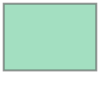

In [10]:
extent

## We will extract OSM POIs

In [11]:
educational_query = OSMNX_POIs.AmenityObject('Education', extent, ['school', 'kindergarten','university', 'college'], inputFolder)        

In [12]:
educational_query

In [13]:
destinations = educational_query.GenerateOSMPOIs()

In [14]:
destinations[:5]

,osmid,geometry,crossing,highway,element_type,barrier,bicycle,foot,horse,motorcar,...,phone_2,phone_3,wall,admin_level,boundary,ways,name:uz-cyr,start_date,short_name:en,name:ko
0,358864754,POINT (69.21058 41.34265),marked,crossing,node,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,359378452,POINT (69.30863 41.31959),NaN,NaN,node,gate,yes,yes,yes,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,359525997,POINT (69.28276 41.32064),NaN,NaN,node,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,964904410,POINT (69.21824 41.19973),NaN,NaN,node,gate,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,999138955,POINT (69.30732 41.25104),NaN,NaN,node,gate,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## We will extract the Roads and convert into a graph, and calculate edge times

In [15]:
# This is the section where we can adjust the road speeds
if not os.path.exists(roadGraph):
    extent = box(*city_extent.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length')
    # save the largest subgraph
    
    # Identify only the largest graph

    # compatible with NetworkX 2.4
    list_of_subgraphs = list(G.subgraph(c).copy() for c in nx.strongly_connected_components(G))
    max_graph = None
    max_edges = 0
    for i in list_of_subgraphs:
        if i.number_of_edges() > max_edges:
            max_edges = i.number_of_edges()
            max_graph = i

    # set your graph equal to the largest sub-graph
    G = max_graph
    
    print('print G')
    print(len(G))
    nx.write_gpickle(G, roadGraph)
else:
    G = nx.read_gpickle(roadGraph)    
    G = gn.convert_network_to_time(G, 'length')

### Inspect the road graph as a shapefile

In [16]:
roads = gn.edge_gdf_from_graph(G)

/Users/thomasgertin3/anaconda3/envs/gostnets2/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [17]:
roads[:2]

,stnode,endnode,ref,bridge,width,maxspeed,service,highway,time,tunnel,junction,lanes,landuse,osmid,name,oneway,mode,access,length,geometry
0,5814616064,5814616062,NaN,NaN,NaN,NaN,NaN,service,12.45708,NaN,NaN,NaN,NaN,614769586,NaN,False,drive,NaN,69.206,"LINESTRING (69.29001 41.30948, 69.29002 41.309..."
1,5814616064,5957852995,NaN,NaN,NaN,NaN,NaN,service,4.65552,NaN,NaN,NaN,NaN,614769586,NaN,False,drive,NaN,25.864,"LINESTRING (69.29001 41.30948, 69.29000 41.309..."


In [18]:
if not os.path.exists(outputFolder + '/OSM_Roads/OSM_Roads.shp'):
    roads['oneway'] = roads.oneway.astype(int)
    roads = roads[['oneway','length','time','mode','geometry']]
    roads.to_file(outputFolder + '/OSM_Roads')

# 1st Analysis: Non-flooded scenario

## Create origins and destinations and snap them to the road graph

In [19]:
# insert origins
origins = gpd.read_file(os.path.join(inputFolder, "tashkent_ghsl2015_pop_250m_pts.shp"))

In [20]:
# snap the origins to the road graph
snapped_origins = gn.pandana_snap_c(G, origins)

In [21]:
destinations.geometry

0       POINT (69.21058 41.34265)
1       POINT (69.30863 41.31959)
2       POINT (69.28276 41.32064)
3       POINT (69.21824 41.19973)
4       POINT (69.30732 41.25104)
                  ...            
1490    POINT (69.18645 41.35817)
1491    POINT (69.18623 41.35744)
1492    POINT (69.21089 41.19061)
1493    POINT (69.16661 41.34217)
1494    POINT (69.31959 41.18589)
Name: geometry, Length: 1495, dtype: geometry

In [22]:
destinations['x'] = destinations.geometry.apply(lambda geometry: geometry.x)

In [ ]:
destinations[:5]

In [24]:
# snap the destinations to the road graph
snapped_destinations = gn.pandana_snap_c(G, destinations)

In [25]:
originNodes = list(snapped_origins['NN'].unique())

In [26]:
destinationNodes = list(snapped_destinations['NN'].unique())

In [27]:
# calculate OD matrix
OD_matrix = gn.calculate_OD(G, originNodes, destinationNodes, fail_value = -1, weight = 'time')

In [28]:
#OD_matrix[:3]

## calculate accessibility
### For each row, the closest facility is the smallest value in the row

In [ ]:
# testing
# closest_facility_per_origin = OD_matrix.min(axis=1)
# closest_facility_per_origin[:5]

In [31]:
closest_facility_per_origin = OD_matrix.min(axis=1)

results = pd.DataFrame([originNodes, closest_facility_per_origin]).transpose()
colName = "travel_time_to_closest_facility"
results.columns = ['NN', colName]

In [32]:
results[:5]

,NN,travel_time_to_closest_facility
0,4.202418e+09,343.20726
1,2.080926e+09,289.75608
2,4.709277e+09,604.38702
3,4.202528e+09,158.40228
4,4.202528e+09,135.20532


In [33]:
snapped_origins_copy = snapped_origins.copy()
output = pd.merge(snapped_origins_copy, results, on = "NN")

In [34]:
# Save baseline results
output.to_csv(os.path.join(outputFolder, "tashkent_accessibility_schools.csv"))

# 2nd Analysis: Flooded scenario

In [36]:
# import simulated flood raster
# The raster is a combined fluvial and pluvial flood raster where the pixel values represent 
# the flood depth in a 250 year flood
tif_path = os.path.join(inputFolder, "ubz_fl_pu_simulated_flood_250yr_tashkent_clipped.tif")
if not os.path.exists(tif_path):
    print('{} not found'.format(tif_path))
    sys.exit()

In [37]:
# the GOSTnets sample raster function needs the rasterio dependency
G = gn.sample_raster(G, tif_path, property_name = 'flood_height')

In [38]:
gn.example_node(G, 2)

(5814616064, {'y': 41.3094792, 'x': 69.2900069, 'osmid': 5814616064, 'flood_height': 3.0})
(1913651200, {'y': 41.2796871, 'x': 69.2610066, 'osmid': 1913651200, 'flood_height': 0.53240126})


### do some checks

In [39]:
G_node_gdf = gn.node_gdf_from_graph(G)
print('total number of nodes: %d' % len(G_node_gdf))

total number of nodes: 45162


In [40]:
print('number of nodes where flood depth positive: %d' % len(G_node_gdf.loc[G_node_gdf.flood_height >= 1]))

number of nodes where flood depth positive: 622


In [41]:
print('number of nodes where flood depth positive: %d' % len(G_node_gdf.loc[G_node_gdf.flood_height >= 3]))

number of nodes where flood depth positive: 354


In [42]:
# In cases where some nodes don't intersect the raster, solve this by setting flood_depth = 0 where this is the case
i = 0
for u, data in G.nodes(data = True):
    if 'flood_height' not in data.keys():
        data['flood_height'] = 0
        i+=1
print(i)

0


## disrupt the network

In [43]:
cutoff_point_to_be_flooded = 1
fail_value = 999999999999999
G_flood = gn.disrupt_network(G, 'flood_height', cutoff_point_to_be_flooded, fail_value)

nodes disrupted: 622
edges disrupted: 2105


In [44]:
#gn.example_node(G_flood, 2)

In [45]:
#gn.example_edge(G_flood, 2)

### Inaccessible population areas and inaccessible schools due to flooding should be removed from the inputs.

In [46]:
import rasterio 

# Open the raster and store metadata
src = rasterio.open(tif_path)

In [47]:
len(origins)

9840

In [48]:
origins_coords = [(x,y) for x, y in zip(origins.geometry.x, origins.geometry.y)]

In [49]:
# Sample the raster at every point location and store values in DataFrame
origins['raster_value'] = [x for x in src.sample(origins_coords)]

In [50]:
#origins[:15]

In [51]:
non_flooded_origins = origins[origins.raster_value < 1]

In [52]:
len(non_flooded_origins)

9558

In [53]:
# convert destinations pandas to a geopandas dataframe
destinations_gpd = gpd.GeoDataFrame(destinations, crs = "epsg:4326", geometry = 'geometry')

In [54]:
len(destinations)

1495

In [55]:
destinations_coords = [(x,y) for x, y in zip(destinations_gpd.geometry.x, destinations_gpd.geometry.y)]

In [56]:
destinations['raster_value'] = [x for x in src.sample(destinations_coords)]

In [57]:
#destinations[:10]

In [58]:
non_flooded_destinations = destinations[destinations.raster_value < 1]

In [59]:
len(non_flooded_destinations)

1454

### snap the non-flooded origin and destination points to the disrupted flooded network

In [66]:
# snap the origins to the road graph
non_flooded_snapped_origins = gn.pandana_snap_c(G_flood, non_flooded_origins)

In [67]:
non_flooded_originNodes = list(non_flooded_snapped_origins['NN'].unique())

In [69]:
non_flooded_snapped_destinations = gn.pandana_snap_c(G_flood, non_flooded_destinations)

In [70]:
non_flooded_destinationsNodes = list(non_flooded_snapped_destinations['NN'].unique())

## calculate OD matrix on flooded network

In [88]:
flooded_OD_matrix = gn.calculate_OD(G_flood, non_flooded_originNodes, non_flooded_destinationsNodes, fail_value = -1, weight = 'time')

In [93]:
# calculate accessibility
# For each row, the closest facility is the smallest value in the row

flooded_output = non_flooded_snapped_origins.copy()

closest_facility_per_origin = flooded_OD_matrix.min(axis=1)

results = pd.DataFrame([non_flooded_originNodes, closest_facility_per_origin]).transpose()
colName = "travel_time_to_closest_facility"
results.columns = ['NN', colName]

In [94]:
flooded_output = pd.merge(flooded_output, results, on = "NN")

In [95]:
outputFolder

'output_folder'

In [96]:
flooded_output.to_csv(os.path.join(outputFolder, "tashkent_accessibility_schools_w_flooding.csv"))

### number of inaccessible schools due to flooding

In [97]:
len(destinations) - len(non_flooded_destinations)

41

### number of inaccessible population pixels due to flooding

In [98]:
len(origins) - len(non_flooded_origins)

282

### compare median travel times between the flooded and non-flooded scenarios?

In [99]:
output[:4]

,VALUE,geometry,x,y,NN,NN_dist,travel_time_to_closest_facility
0,44.999962,POINT (69.46213 41.41966),69.462133,41.419658,4202418387,0.000498,343.20726
1,44.999962,POINT (69.46402 41.41966),69.464024,41.419658,2080926193,0.000274,289.75608
2,33.067554,POINT (69.44889 41.41398),69.448891,41.413983,4709277426,0.008251,604.38702
3,33.067554,POINT (69.45078 41.41398),69.450783,41.413983,4202527651,0.009406,158.40228


In [100]:
len(output)

9840

In [101]:
output["travel_time_to_closest_facility"].mean()

120.87338565130662

In [102]:
output["travel_time_to_closest_facility"].median()

86.77851000000001

In [103]:
flooded_output[:4]

,VALUE,geometry,raster_value,x,y,NN,NN_dist,travel_time_to_closest_facility
0,44.999962,POINT (69.46213 41.41966),[0.0],69.462133,41.419658,4202418387,0.000498,343.20726
1,44.999962,POINT (69.46402 41.41966),[0.0],69.464024,41.419658,2080926193,0.000274,289.75608
2,33.067554,POINT (69.44889 41.41398),[0.0],69.448891,41.413983,4709277426,0.008251,604.38702
3,33.067554,POINT (69.45078 41.41398),[0.0],69.450783,41.413983,4202527651,0.009406,158.40228


In [116]:
# if this returns zero results, than all origin-destination routes appear to be traversible
flooded_output[flooded_output.travel_time_to_closest_facility < 0]

,VALUE,geometry,raster_value,x,y,NN,NN_dist,travel_time_to_closest_facility


In [104]:
len(flooded_output)

9558

In [105]:
# the mean is probably high because there are probably some non-flooded origin points that are only connected to the disrupted part of the network
flooded_output["travel_time_to_closest_facility"].mean()

46453232894030.59

In [106]:
flooded_output["travel_time_to_closest_facility"].median()

89.07381000000001

### find number of disrupted trips

In [115]:
flooded_output[flooded_output.travel_time_to_closest_facility >= fail_value]

,VALUE,geometry,raster_value,x,y,NN,NN_dist,travel_time_to_closest_facility
62,143.582840,POINT (69.46024 41.40263),[0.43286],69.460241,41.402634,2083126857,0.000628,1.000000e+15
963,167.303757,POINT (69.23892 41.36480),[0.0],69.238923,41.364802,7232076258,0.001146,2.000000e+15
1238,219.719772,POINT (69.23514 41.35913),[0.64267683],69.235140,41.359127,4615656700,0.000131,2.000000e+15
1239,276.132355,POINT (69.23703 41.35913),[0.7592444],69.237032,41.359127,4615656702,0.000440,1.000000e+15
3617,214.416229,POINT (69.15380 41.31940),[0.61966425],69.153801,41.319403,3957665565,0.001891,1.000000e+15
...,...,...,...,...,...,...,...,...
9158,3468.014404,POINT (69.27486 41.20591),[0.0],69.274864,41.205907,4634088653,0.001056,1.000000e+15
9159,3468.014404,POINT (69.27676 41.20591),[0.0],69.276755,41.205907,4634088653,0.000966,1.000000e+15
9209,1741.670532,POINT (69.27676 41.20402),[0.0],69.276755,41.204015,4634088641,0.001087,2.000000e+15
9210,1741.670532,POINT (69.27865 41.20402),[0.0],69.278647,41.204015,4634088641,0.000814,2.000000e+15
